Formatting the .xls file is very important before analyzing the data here. 
    Move the Excel sheet labeled 'Data' as the 1st sheet, not the last. 
    Label the columns as their corresponding FA, not 'Column 1, ..2, ...etc.' 
    You must manually enter the tube ID numbers that correspond to the lipid species (i.e., 1.1, 1.2, ...etc. or however you labeled) - USE THE 'SAMPLE' COLUMN
    You must manually enter the genotypes that each row corresponds to -- DO NOT CREATE A NEW COLUMN. USE THE INJ COLUMN

Obtained from Donghee Hoh

Patrick Horn's method of FA analysis: 
    1. 3_moles: (FA / corresponding 15:0 value) * moles of Tri15:0-TAG standard
    2. %_composition: (3_moles FA / sum of all FAs excluding 15:0) * 100

In [32]:
# Color parameters

# Edit a dictionary for later coloring of graphs 
condition_coloring = {
    'Control' : 'black',
    'Heat' : 'darkorange'
}

lipid_coloring = {
    'MGDG': 'indigo', 
    'DGDG': 'violet', 
    'PG': 'purple', 
    'PC': 'plum', 
    'PI/PE' : 'palevioletred',
    'SQDG': 'mediumorchid',
    'total FA' : 'lightpink'
}

In [4]:
# Import libraries & define functions for later use 
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns


# OLD DH CODE: 

# define a standard error function matching the R script
    # (the matching functions for mean and std are already included in numpy)
# def se(data): 
#     return np.std(data, ddof=1) / np.sqrt(len(data))

# # define a function to find descendantes from a folder, with a certain filename
# def findDescendants( filename, folder="." ):
#     result = []
#     for f in os.listdir(folder):
#         sub_path = folder + "/" + f
#         if os.path.isdir(sub_path):
#             result += findDescendants( filename, folder=sub_path )
#         elif f == filename:
#             result.append( sub_path )
#     return result
    

# # supress a sporadic warning on making calls like d3["index"] = d3.index
# # you can comment this if you are worried
# import warnings
# warnings.filterwarnings('ignore')

In [5]:
# Define the working directory, lipid specifications, and edit the df

# OLD DH CODE: 
#Copy paste your file name.
# file_name = "All_runs_together_Data.xls"  #Put the file name here

#Identify what kind of FA species are in your sample
# FA_species = "16|18"  # e.g., "16|18|20|22" for seeds.

# #Identify the threshold for ploting 
# threshold = 0 # any FA mean among all genotypes is less than 1% among all genotypes, this FA will not be plotted.

# #how many genotypes do you have
# num_of_genotype = 9

# Read the file location of the data 
df = pd.read_excel("/Users/shannondonnelly/Desktop/BENNING_LAB/All_runs_together_Data.xls")
# Rename a column 
df = df.rename(columns={'Run' : 'Lipid Species'})
df

,Condition,HeaderValue,SampleName,Location,Genotype,Sample,Lipid Species,14:0,15:0,16:0,16:1 d7 & d9,16:1 d3 & d11,16:2,16:3,18:0,18:1 d9,18:1 d11,18:2,18:3
0,NaN,50.0,hexane,Vial 100,Hexane,NaN,1.0,0.0,1724516.50,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
1,Control,17.0,1,Vial 2,Col-0,1.1,2.0,0.0,2313498.00,0.000000,0.0,0.000000,0.0,478.310211,0.0,0.0,21.805847,20.790287,44.130939
2,Control,4.0,2,Vial 3,Col-0,1.2,3.0,0.0,2297239.25,0.000000,0.0,0.388212,0.0,753.566528,0.0,0.0,23.422724,8.253143,74.639854
3,Control,NaN,3,Vial 4,Col-0,1.3,4.0,0.0,3125032.00,0.000000,0.0,0.000000,0.0,96.391953,0.0,0.0,1.603400,0.517830,7.308637
4,Control,NaN,4,Vial 5,Col-0,1.4,5.0,0.0,3113485.00,0.349998,0.0,0.903736,0.0,1216.319458,0.0,0.0,39.911358,20.261356,81.126556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,NaN,NaN,NaN,NaN,NaN,28.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,NaN,NaN,NaN,NaN,NaN,28.?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,NaN,NaN,NaN,NaN,NaN,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,NaN,NaN,NaN,NaN,NaN,19.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Perform calculations to get a % composition of the FAs for each lipid species

# Calculate the 3_moles value based on the 15:0 standard assuming 50 ul (ug) was added to sample 
moles_of_std = 0.00000006533897862

# Divide each column value by its respective 15:0 value 
    # Get the value in the '15:0' column
divider = df.loc[:,'15:0']*moles_of_std
    # Divide each subsequent column by the '15:0' value
columns = ['15:0', '16:0', '16:1 d7 & d9', '16:1 d3 & d11', '16:2',
       '16:3', '18:0', '18:1 d9', '18:1 d11', '18:2', '18:3']
for column in columns: 
    df[[column]] = df[[column]].div(df['15:0'], axis =0)

# Calculate % composition 
columns_to_sum = ['16:0', '16:1 d7 & d9', '16:1 d3 & d11', '16:2',
       '16:3', '18:0', '18:1 d9', '18:1 d11', '18:2', '18:3']
    # Calculate the sum of each row for the specified columns
row_sums = df[columns_to_sum].sum(axis=1)
    # Divide thee 3_moles value by the sum of all FAs
divider = row_sums
    # Divide each relevant column by the sum of all FAs
        # At this point, we don't care about the 15:0 value anymore, so the columns shift to the right starting by dividing 16:0, not 15:0 as before
for column in columns_to_sum:
    df[[column]] = df[[column]].div(divider, axis=0)
    # Multiply all the affected rows by 100 to obtain % values
df[columns_to_sum] *= 100
df

,Condition,HeaderValue,SampleName,Location,Genotype,Sample,Lipid Species,14:0,15:0,16:0,16:1 d7 & d9,16:1 d3 & d11,16:2,16:3,18:0,18:1 d9,18:1 d11,18:2,18:3
0,NaN,50.0,hexane,Vial 100,Hexane,NaN,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Control,17.0,1,Vial 2,Col-0,1.1,2.0,0.0,1.0,0.000000,0.0,0.000000,0.0,84.651088,0.0,0.0,3.859187,3.679454,7.810270
2,Control,4.0,2,Vial 3,Col-0,1.2,3.0,0.0,1.0,0.000000,0.0,0.045127,0.0,87.596467,0.0,0.0,2.722716,0.959366,8.676324
3,Control,NaN,3,Vial 4,Col-0,1.3,4.0,0.0,1.0,0.000000,0.0,0.000000,0.0,91.088919,0.0,0.0,1.515189,0.489342,6.906550
4,Control,NaN,4,Vial 5,Col-0,1.4,5.0,0.0,1.0,0.025757,0.0,0.066506,0.0,89.509464,0.0,0.0,2.937094,1.491042,5.970138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,NaN,NaN,NaN,NaN,NaN,28.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,NaN,NaN,NaN,NaN,NaN,28.?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,NaN,NaN,NaN,NaN,NaN,17.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,NaN,NaN,NaN,NaN,NaN,19.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Label the appropriate numbers as the lipid species + Output a new .csv

# Create an empty list to store the labels
labels = []

# Loop through each number in the 'Number' column
for number in df['Sample']:
    try: 
        last_digit = int(str(number)[-1])  # Extract the last digit of the number
        
        # Assign labels based on the last digit
        if last_digit == 1:
            labels.append('MGDG')
        elif last_digit == 2:
            labels.append('PG')
        elif last_digit == 3:
            labels.append('DGDG')
        elif last_digit == 4:
            labels.append('SQDG')
        elif last_digit == 5:
            labels.append('PI/PE')
        elif last_digit == 6:
            labels.append('PC')
        elif last_digit == 7:
            labels.append('total FA')
        else:
            labels.append('')  # Assign an empty string if the condition is not met
    except ValueError:
        labels.append('')
# Add the labels as a new column in the DataFrame
df['Lipid Species'] = labels

# Output a new updated file for analysis 
df.to_csv("AllDataTogether_normalization.csv", na_rep="NaN")

# Drop the rows we dont care about 
df = df.drop(columns = ['HeaderValue', 'SampleName', 'Location', 'Sample', '15:0', '14:0'])

df

,Condition,Genotype,Lipid Species,16:0,16:1 d7 & d9,16:1 d3 & d11,16:2,16:3,18:0,18:1 d9,18:1 d11,18:2,18:3
0,NaN,Hexane,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Control,Col-0,MGDG,0.000000,0.0,0.000000,0.0,84.651088,0.0,0.0,3.859187,3.679454,7.810270
2,Control,Col-0,PG,0.000000,0.0,0.045127,0.0,87.596467,0.0,0.0,2.722716,0.959366,8.676324
3,Control,Col-0,DGDG,0.000000,0.0,0.000000,0.0,91.088919,0.0,0.0,1.515189,0.489342,6.906550
4,Control,Col-0,SQDG,0.025757,0.0,0.066506,0.0,89.509464,0.0,0.0,2.937094,1.491042,5.970138
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,NaN,NaN,DGDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,NaN,NaN,PG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,NaN,NaN,total FA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Average the replicates and generate new df1

# Most genotypes/conditions have 2 replicates, but some don't. For that reason, you must define a new function. If you do not, groupby will output NaN values for the single replicate 

df1 = pd.DataFrame(columns=df.columns)
df2 = pd.DataFrame(columns=df.columns)

# List of columns to calculate average for
columns_to_average = ['16:0', '16:1 d7 & d9', '16:1 d3 & d11', '16:2', '16:3', '18:0', '18:1 d9', '18:1 d11', '18:2', '18:3']
# A loop that states: if the genotype ID appears twice, take it's average and insert the values under the relevant column names 
for temperature in ['Control', 'Heat']:
    for genotype in df['Genotype '].unique():
        for lipid_species in df['Lipid Species'].unique():
            mask = (df['Condition '] == temperature) & (df['Genotype '] == genotype) & (df['Lipid Species'] == lipid_species)
            # If the sum is greater than or equal to 2:
            if mask.sum() >= 2:
                averaged_values= df.loc[mask, columns_to_average] #.mean()
                averaged_values['Genotype '] = genotype
                averaged_values['Condition '] = temperature
                averaged_values['Lipid Species'] = lipid_species
                df1 = df1.append(averaged_values, ignore_index=True)

                # Repeat the sequence - for std err 
                averaged_values= df.loc[mask, columns_to_average].mean()
                averaged_values['Genotype '] = genotype
                averaged_values['Condition '] = temperature
                averaged_values['Lipid Species'] = lipid_species
                df1 = df1.append(averaged_values, ignore_index=True)
            # If the genotype and temperature IDs appear only once, 
            else:
                original_values= df.loc[mask, columns_to_average]
                df2 = df2.append(original_values, ignore_index=True)

df1.to_csv("/Users/shannondonnelly/Desktop/BENNING_LAB/averaged_lipids.csv")

# 2 replicate IDs
df1_nostd = df1.groupby(['Genotype ', 'Condition ', 'Lipid Species']).mean()
df1 = df1.groupby(['Genotype ', 'Condition ', 'Lipid Species']).agg(['mean','std'])
# 1 replicate IDs
df2
df1

/var/folders/ns/rc81wsbn56xfkm96h1cx8b2w0000gq/T/ipykernel_64786/2935697079.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(original_values, ignore_index=True)
/var/folders/ns/rc81wsbn56xfkm96h1cx8b2w0000gq/T/ipykernel_64786/2935697079.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(original_values, ignore_index=True)
/var/folders/ns/rc81wsbn56xfkm96h1cx8b2w0000gq/T/ipykernel_64786/2935697079.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(original_values, ignore_index=True)
/var/folders/ns/rc81wsbn56xfkm96h1cx8b2w0000gq/T/ipykernel_64786/2935697079.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

16:0           16:1 d7 & d9            \
                                        mean       std         mean       std   
Genotype  Condition  Lipid Species                                              
Col-0     Control    DGDG           0.000000  0.000000     0.000000  0.000000   
                     MGDG           0.000000  0.000000     0.000000  0.000000   
                     PC             0.640877  0.142165     0.000000  0.000000   
                     PG             0.000000  0.000000     0.000000  0.000000   
                     PI/PE          0.000000  0.000000     0.000000  0.000000   
...                                      ...       ...          ...       ...   
pg-18     Control    PC             0.156104  0.156104     0.018583  0.018583   
                     PG             0.000000  0.000000     0.000000  0.000000   
                     PI/PE          0.000000  0.000000     0.000000  0.000000   
                     SQDG           0.000000  0.000000     0.000000  0.000000   
                     total FA       0.000000  0.000000     0.000000  0.000000   

                                   16:1 d3 & d11                16:2  \
                                            mean       std      mean   
Genotype  Condition  Lipid Species                                     
Col-0     Control    DGDG               0.033353  0.033353  0.000000   
                     MGDG               0.034853  0.034853  0.000000   
                     PC                 0.887201  0.000049  0.168611   
                     PG                 0.053750  0.008623  0.000000   
                     PI/PE              0.051434  0.002458  0.000000   
...                                          ...       ...       ...   
pg-18     Control    PC                 0.235197  0.235197  0.117195   
                     PG                 0.043576  0.002071  0.000000   
                     PI/PE              0.038638  0.001520  0.000000   
                     SQDG               0.039481  0.000021  0.000000   
                     total FA           0.047846  0.006158  0.000000   

                                                   16:3            18:0       \
                                         std       mean        std mean  std   
Genotype  Condition  Lipid Species                                             
Col-0     Control    DGDG           0.000000  89.735577   1.353342  0.0  0.0   
                     MGDG           0.000000  78.852912   5.798176  0.0  0.0   
                     PC             0.003811  58.871597   3.235161  0.0  0.0   
                     PG             0.000000  85.603245   1.993221  0.0  0.0   
                     PI/PE          0.000000  63.974300   8.130302  0.0  0.0   
...                                      ...        ...        ...  ...  ...   
pg-18     Control    PC             0.117195  78.184645  20.998588  0.0  0.0   
                     PG             0.000000  84.487322  14.183415  0.0  0.0   
                     PI/PE          0.000000  62.458145   2.023843  0.0  0.0   
                     SQDG           0.000000  89.192929   0.602437  0.0  0.0   
                     total FA       0.000000  80.606116   5.282490  0.0  0.0   

                                   18:1 d9       18:1 d11                18:2  \
                                      mean  std      mean       std      mean   
Genotype  Condition  Lipid Species                                              
Col-0     Control    DGDG              0.0  0.0  1.588760  0.073572  0.542518   
                     MGDG              0.0  0.0  5.667583  1.808396  4.487047   
                     PC                0.0  0.0  0.642723  0.002138  6.094088   
                     PG                0.0  0.0  2.619480  0.103236  0.930244   
                     PI/PE             0.0  0.0  0.842744  0.037981  1.140372   
...                                    ...  ...       ...       ...       ...   
pg-18     Control    PC                0.0  0.

In [75]:
df1_nostd.loc[('Col-0', 'Control')].values.sum()

699.9999999999998

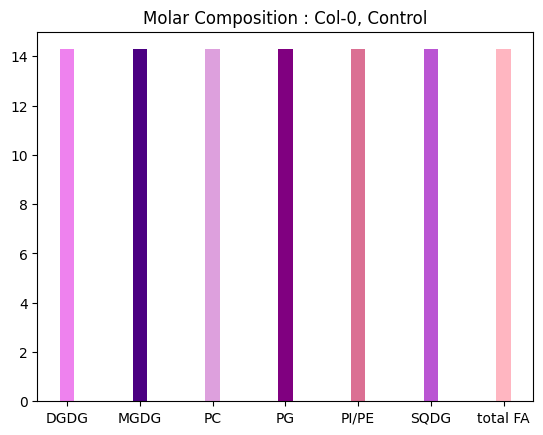

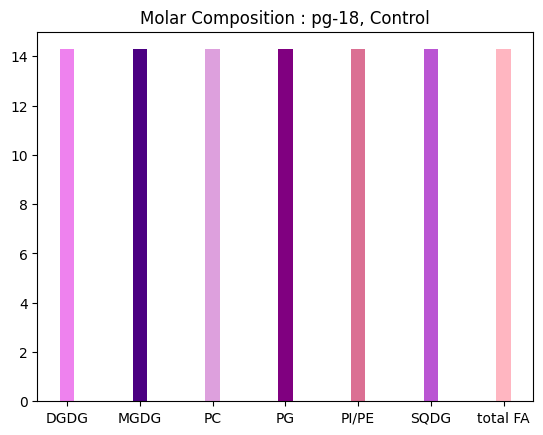

In [74]:
# Calculate molar percent composition for all lipid species 
    # According to https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3197303/

# Could be used to store new data in a different dataframe
molar_ratio_df = pd.DataFrame()
for lipid in df1.index.get_level_values('Lipid Species').unique():
    molar_ratio_df[lipid] = 0 

# The columns that contain your fatty acids 
columns = ['16:0', '16:1 d7 & d9', '16:1 d3 & d11', '16:2',
       '16:3', '18:0', '18:1 d9', '18:1 d11', '18:2', '18:3']

# In my lipid set, these 2 genotypes did not have heat data so I had to generate a separate loop for it
    # For even sets, you can forgo this first loop
genotypes = ['Col-0', 'pg-18']
conditions = ['Control']

total_sums = df1_nostd.loc[('Col-0', 'Control')].values.sum()

for genotype in genotypes:
    for condition in conditions:
        total_sums = df1_nostd.loc[(genotype, condition)].values.sum()
        ax = plt.subplot(111)
        plt.title('Molar Composition : ' + genotype + ', ' + condition)
        for column in columns: 
            # Find all unique identifers in the column labeled Lipid Species 
                # Because this is plotting a multiindex, technically the column is a level 
            for lipid in df1.index.get_level_values('Lipid Species').unique():
                for column in columns: 
                    lipid_sums = df1_nostd.loc[(genotype, condition, lipid)].values.sum()
                    molar_ratio = 100 / total_sums
                    molar_ratio *= 100
                    x = lipid
                    ax.bar(x, height = molar_ratio, 
                        color = lipid_coloring[lipid], alpha = 0.2, align = 'center',
                        width = 0.2)
                        #yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
        plt.show()
        

# # The second loop for genotypes that have both control and heat data 

# for genotype in ['abc1k1', 'abc1k1k3', 'abc1k3', 'abc1k6', 'abc1k7', 'fbn4-1',
#        'fbn4-2/2']:  
#     for condition in df1.index.get_level_values('Condition ').unique():
#         ax = plt.subplot(111)
#         plt.title('Molar Composition :' + genotype + ', ' + condition)
#         for column in columns: 
#                 row_sums = df[column].sum()
#         for lipid in df1.index.get_level_values('Lipid Species').unique():
#             for column in columns: 
#                 lipid_sums = df[column].sum()
#             molar_ratio = lipid_sums // total_sums
#             molar_ratio *= 100
#             molar_ratio_df[lipid] = molar_ratio
#             x = lipid
#             ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
#                 color = lipid_coloring[lipid], alpha = 0.2, align = 'center',
#                 width = 0.2, 
#                 yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
#         plt.show()

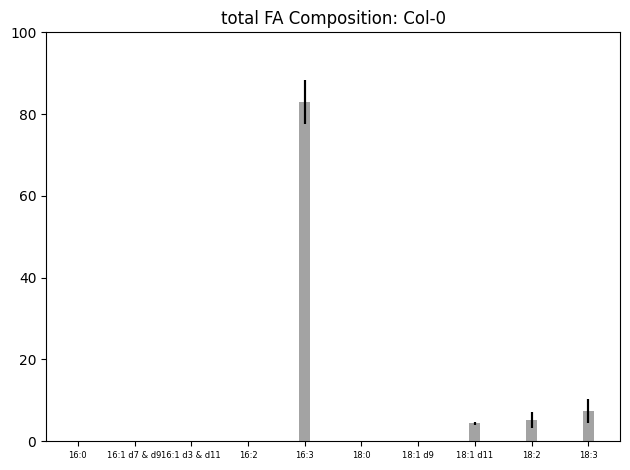

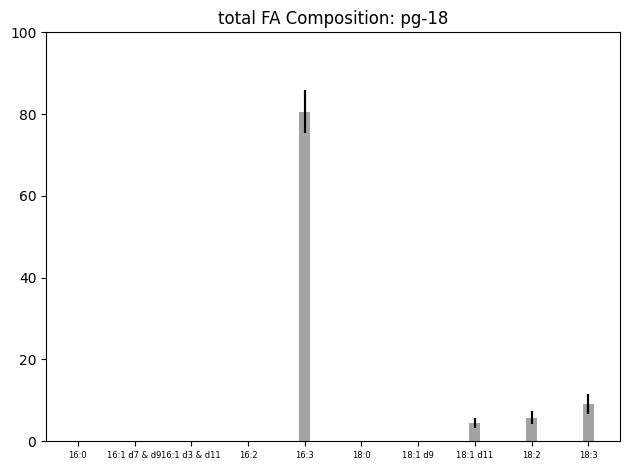

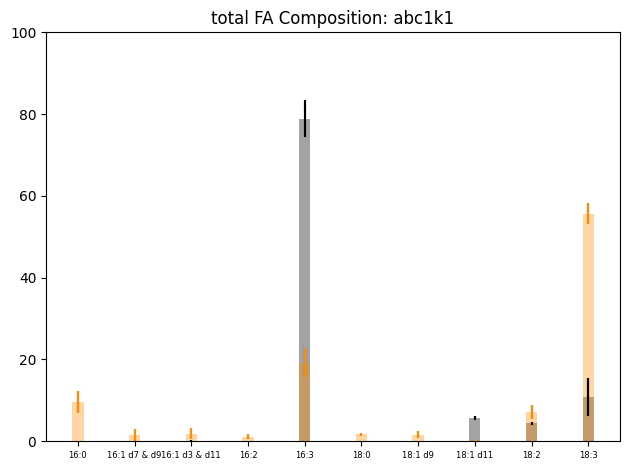

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


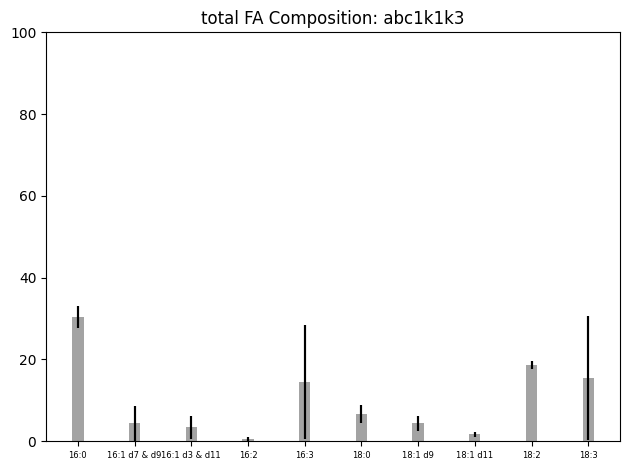

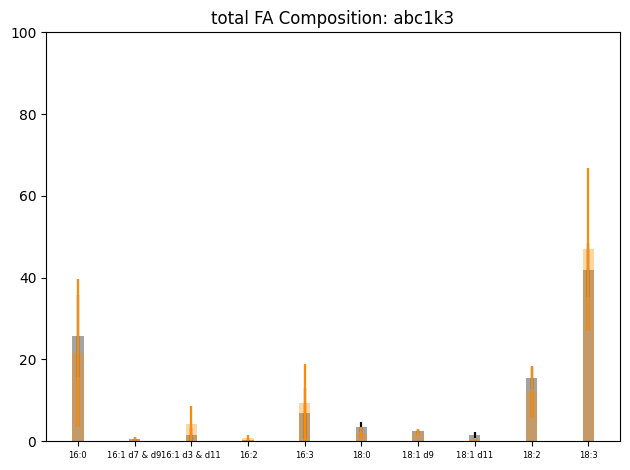

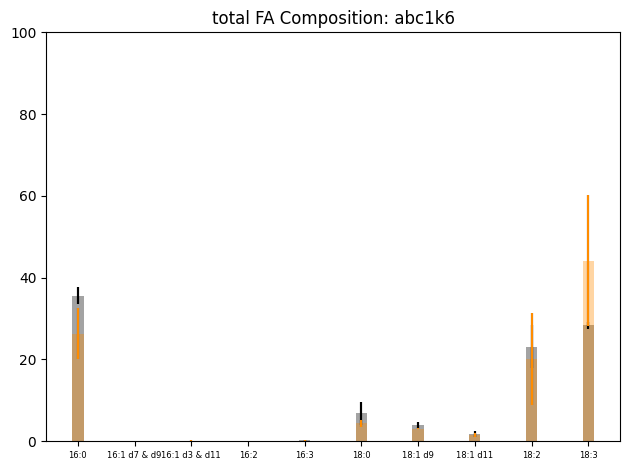

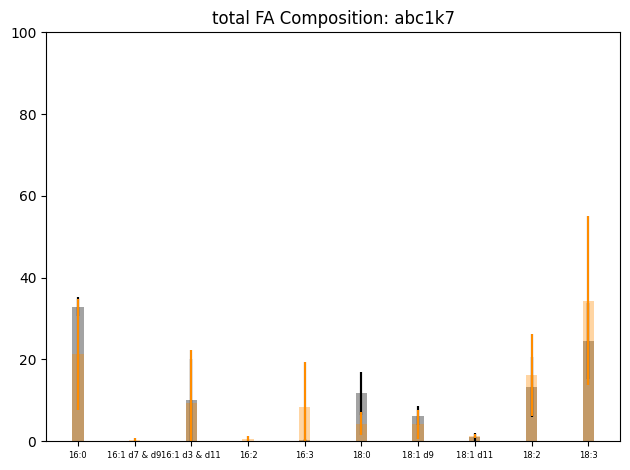

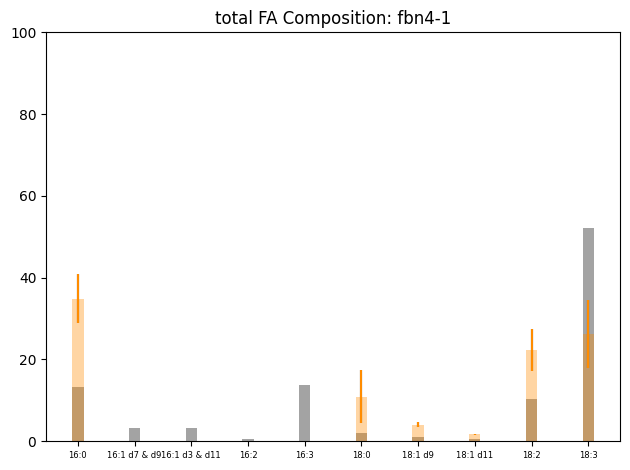

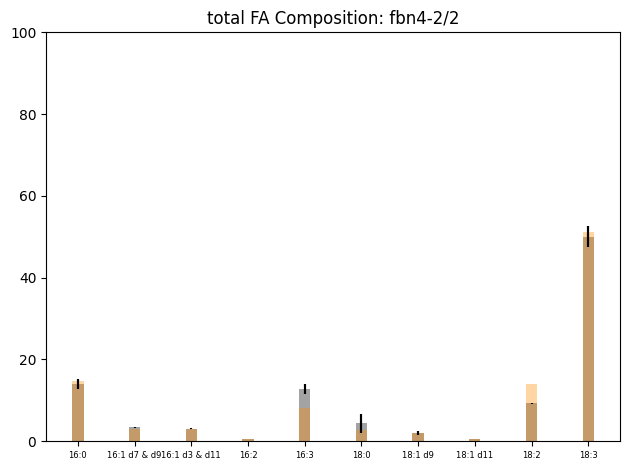

In [23]:
# For genotypes that do not have heat data: 
for genotype in ['Col-0', 'pg-18']:
    ax = plt.subplot(111)
    for condition in ['Control']:
        # ax = plt.subplot(111)
        for lipid in ['total FA']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()


for genotype in ['abc1k1', 'abc1k1k3', 'abc1k3', 'abc1k6', 'abc1k7', 'fbn4-1',
       'fbn4-2/2']:  # df1.index.get_level_values('Genotype ').unique():
    ax = plt.subplot(111)
    for condition in df1.index.get_level_values('Condition ').unique():
        # ax = plt.subplot(111)
        for lipid in ['total FA']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()



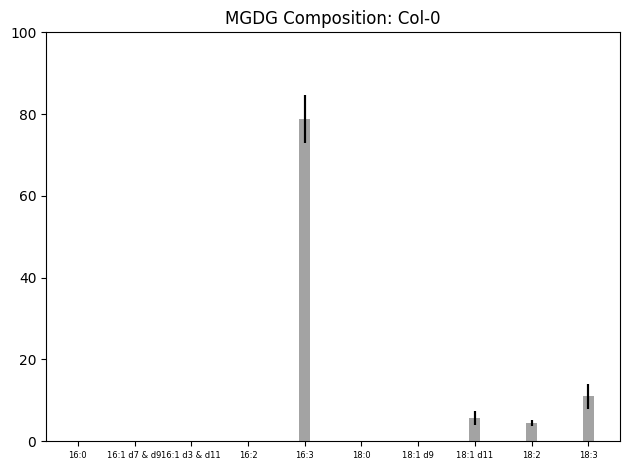

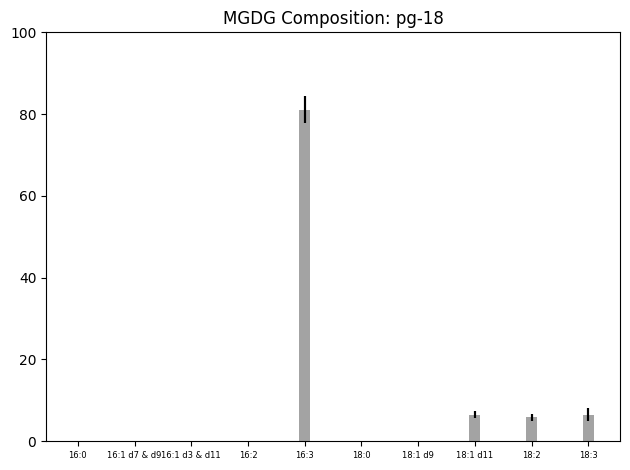

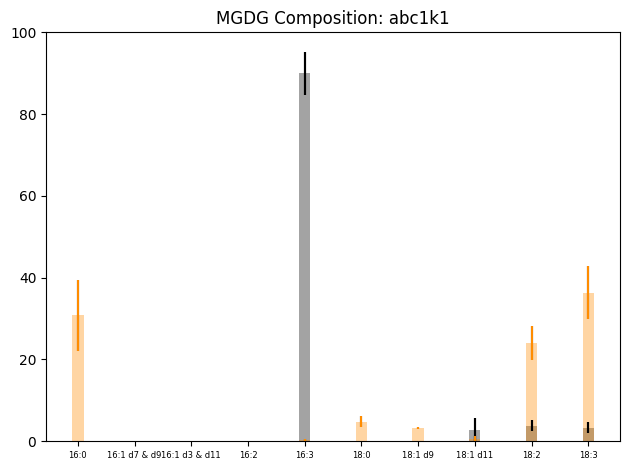

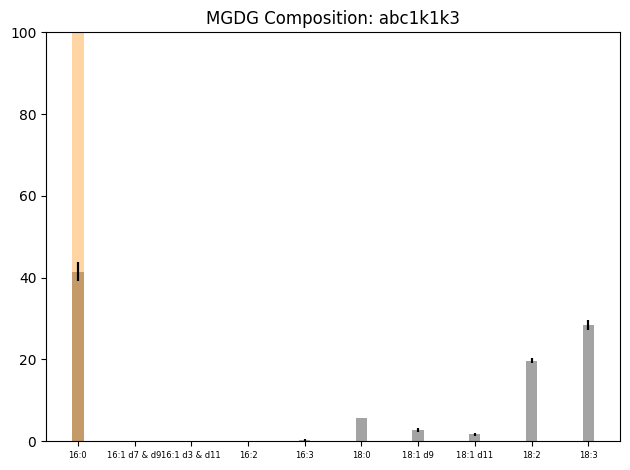

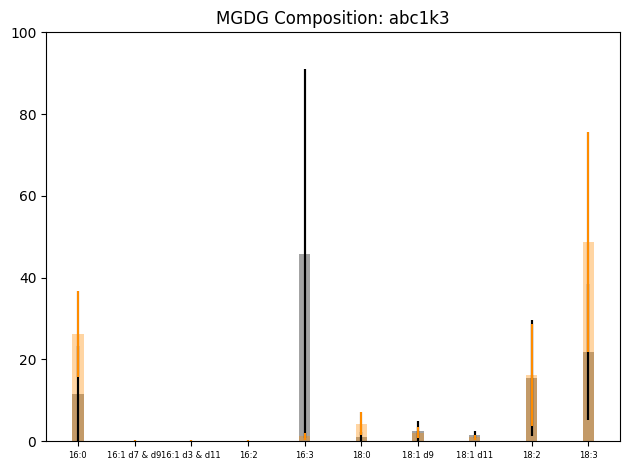

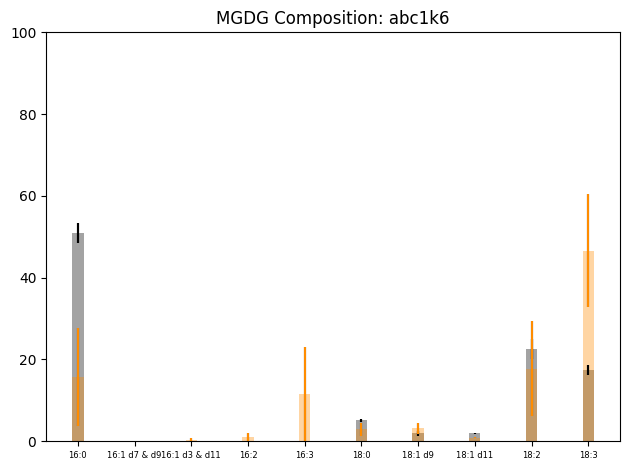

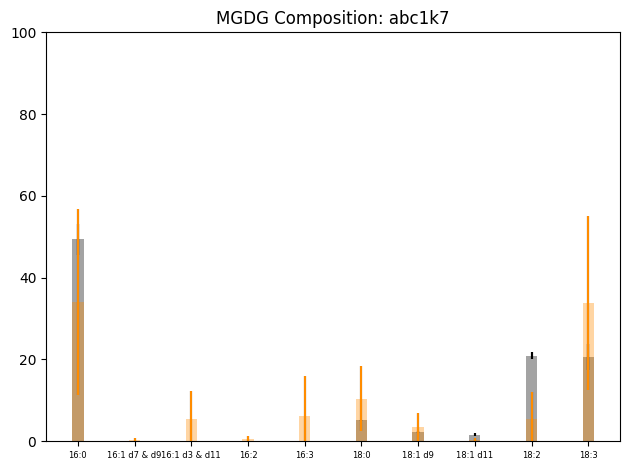

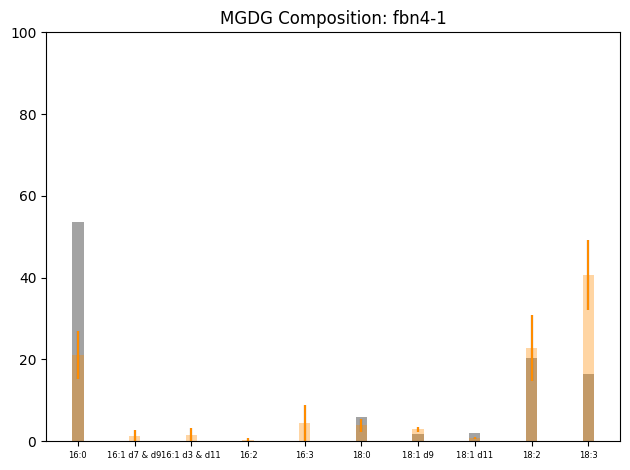

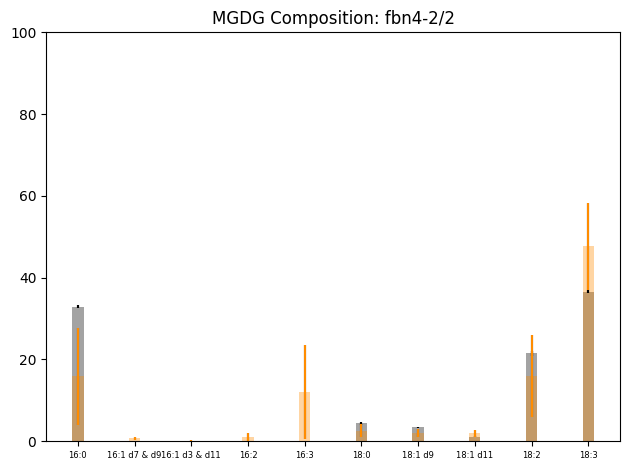

In [19]:
# For genotypes that do not have heat data: 
for genotype in ['Col-0', 'pg-18']:
    ax = plt.subplot(111)
    for condition in ['Control']:
        ax = plt.subplot(111)
        for lipid in ['MGDG']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()


for genotype in ['abc1k1', 'abc1k1k3', 'abc1k3', 'abc1k6', 'abc1k7', 'fbn4-1',
       'fbn4-2/2']:  # df1.index.get_level_values('Genotype ').unique():
    ax = plt.subplot(111)
    for condition in df1.index.get_level_values('Condition ').unique():
        ax = plt.subplot(111)
        for lipid in ['MGDG']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()



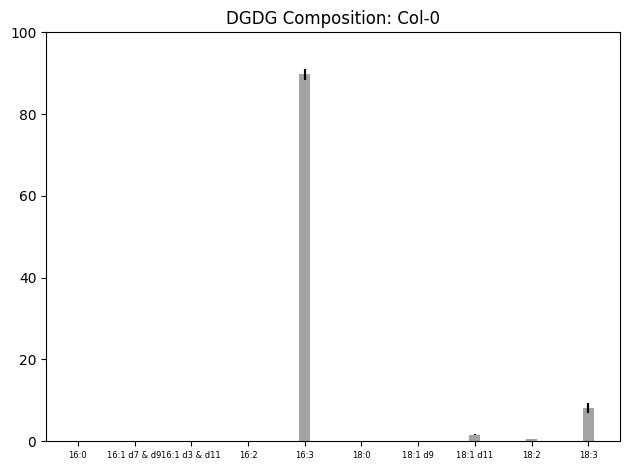

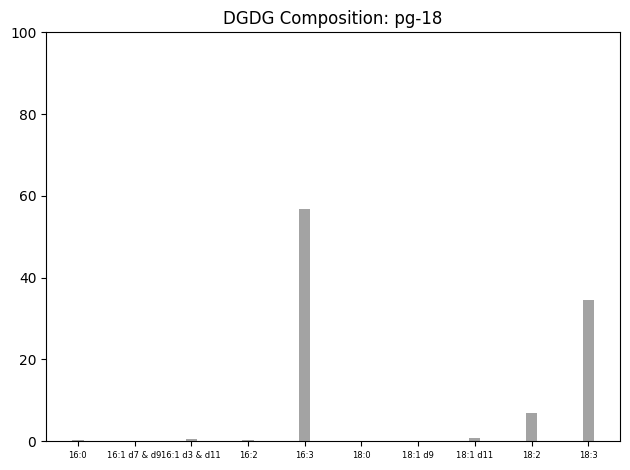

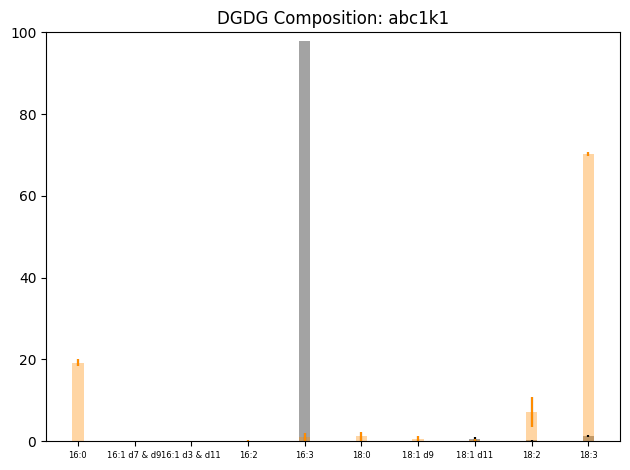

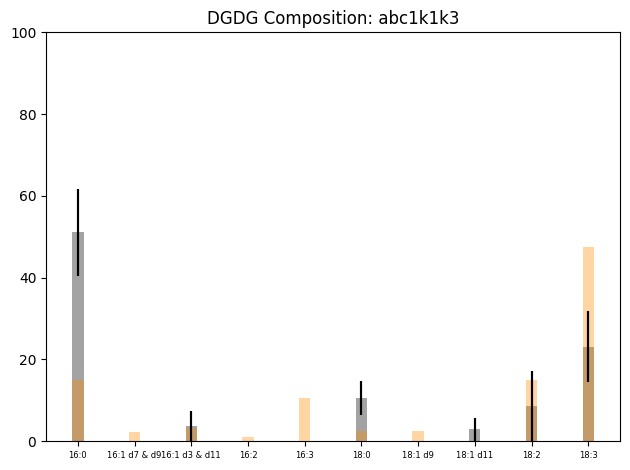

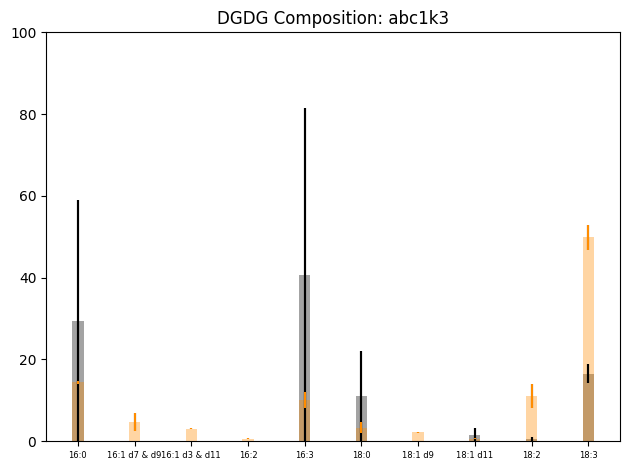

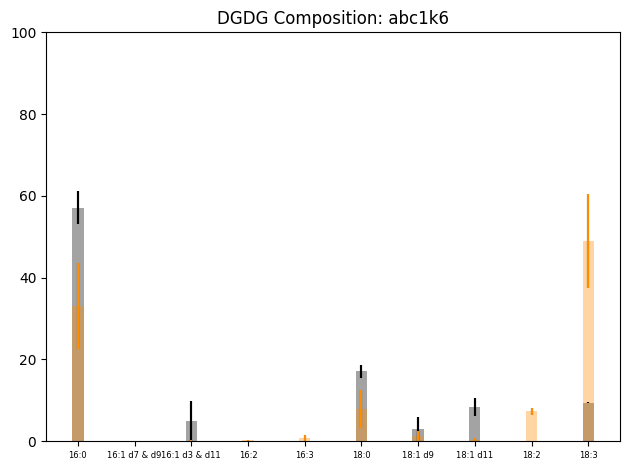

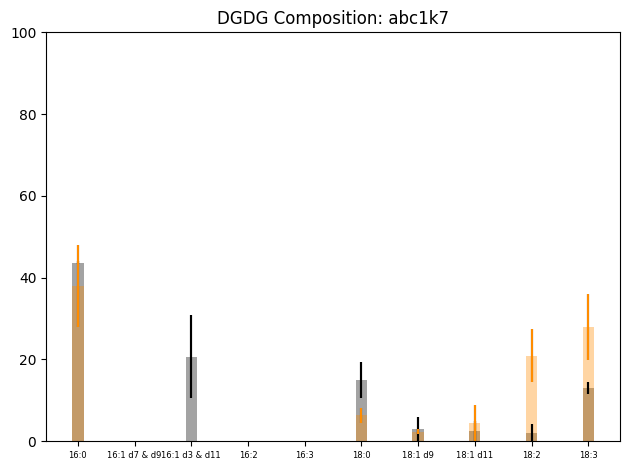

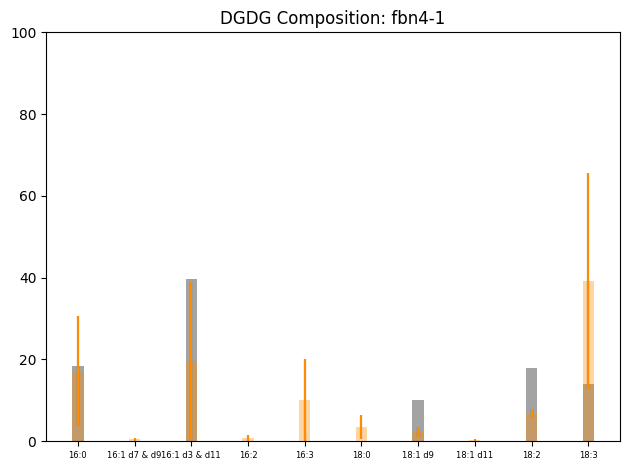

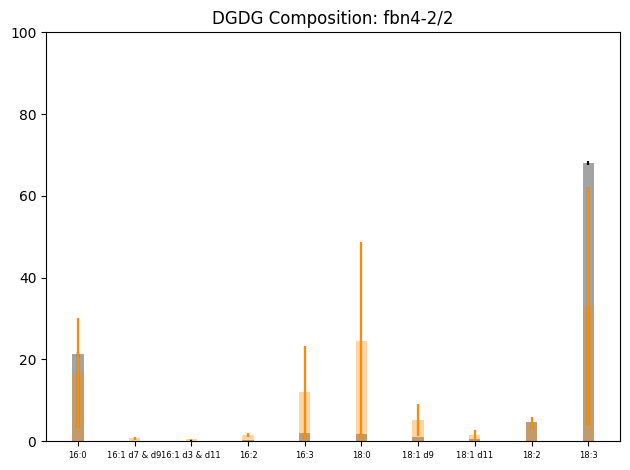

In [20]:
# For genotypes that do not have heat data: 
for genotype in ['Col-0', 'pg-18']:
    ax = plt.subplot(111)
    for condition in ['Control']:
        ax = plt.subplot(111)
        for lipid in ['DGDG']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()


for genotype in ['abc1k1', 'abc1k1k3', 'abc1k3', 'abc1k6', 'abc1k7', 'fbn4-1',
       'fbn4-2/2']:  # df1.index.get_level_values('Genotype ').unique():
    ax = plt.subplot(111)
    for condition in df1.index.get_level_values('Condition ').unique():
        ax = plt.subplot(111)
        for lipid in ['DGDG']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()



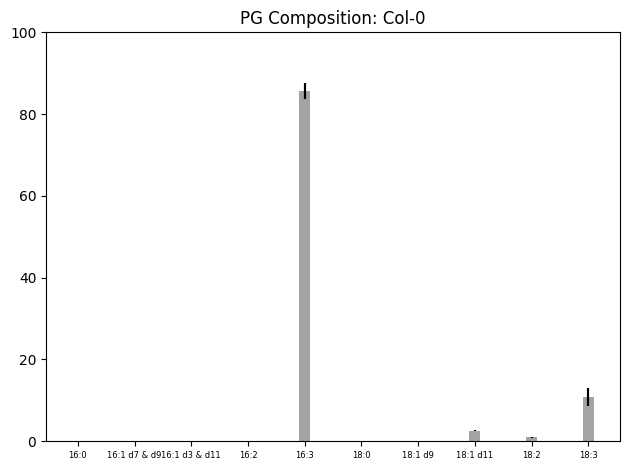

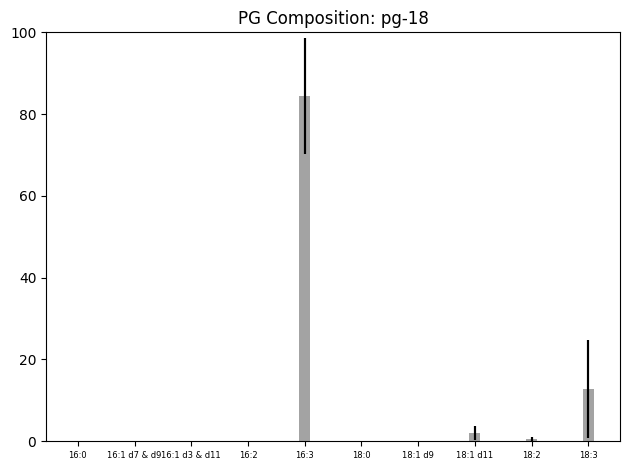

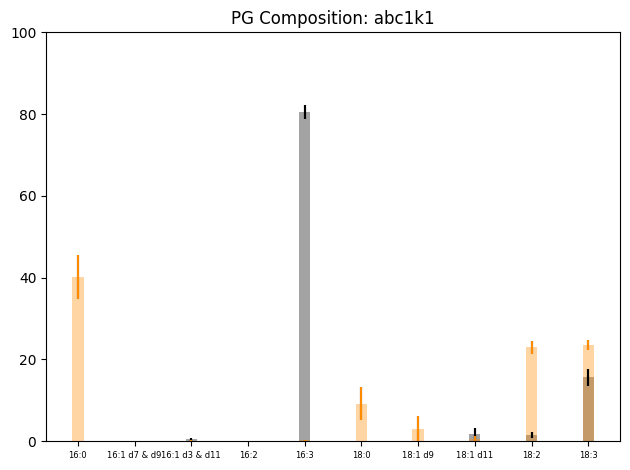

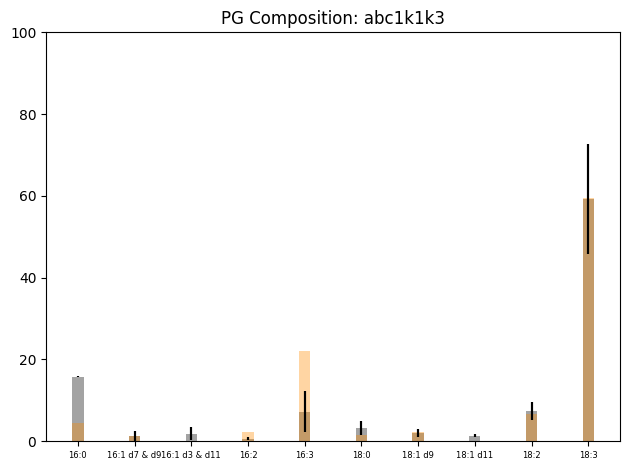

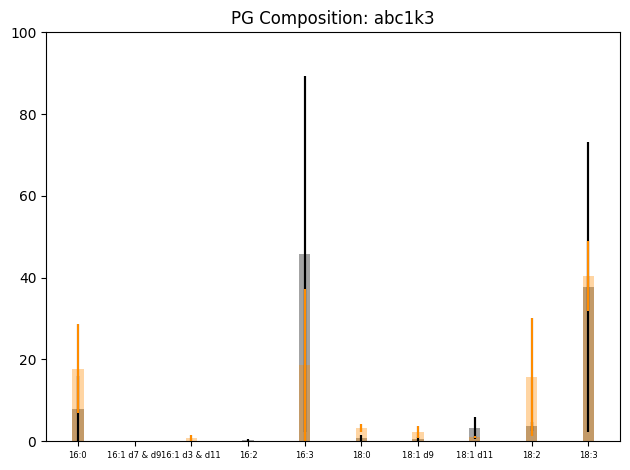

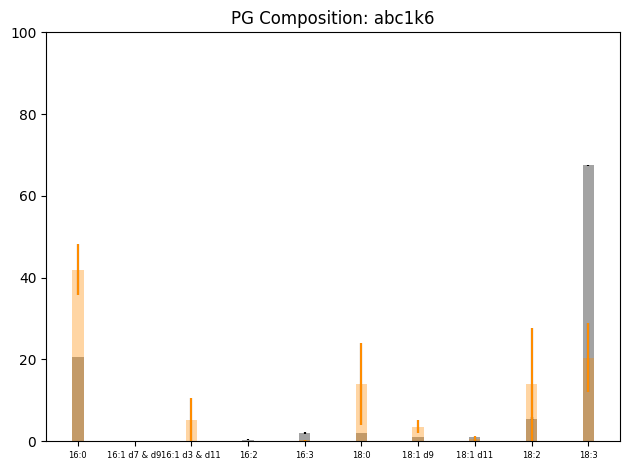

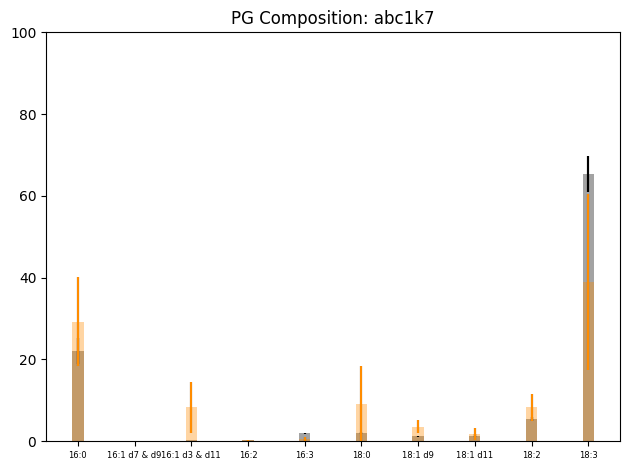

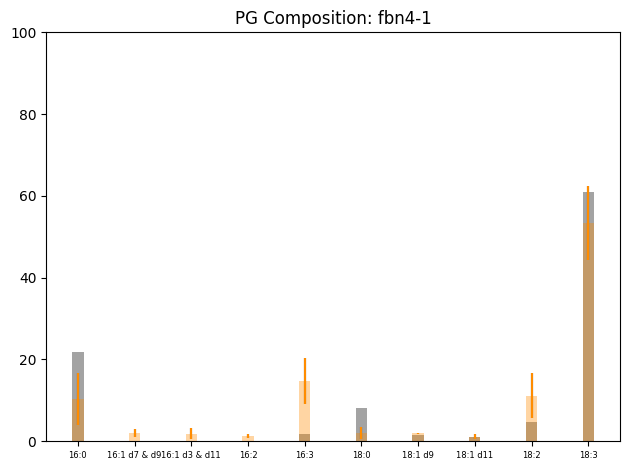

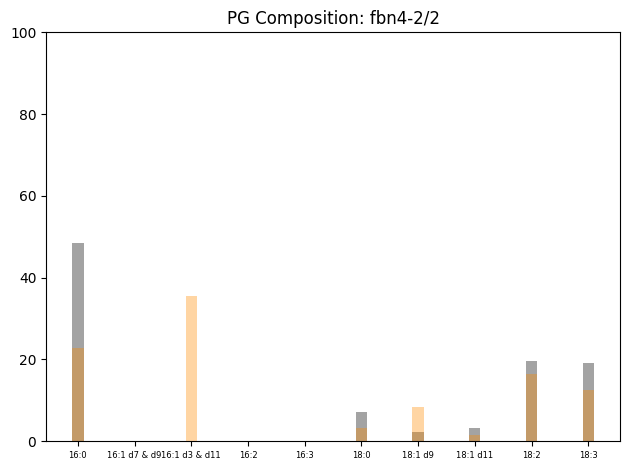

In [21]:
# For genotypes that do not have heat data: 
for genotype in ['Col-0', 'pg-18']:
    ax = plt.subplot(111)
    for condition in ['Control']:
        ax = plt.subplot(111)
        for lipid in ['PG']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()


for genotype in ['abc1k1', 'abc1k1k3', 'abc1k3', 'abc1k6', 'abc1k7', 'fbn4-1',
       'fbn4-2/2']:  # df1.index.get_level_values('Genotype ').unique():
    ax = plt.subplot(111)
    for condition in df1.index.get_level_values('Condition ').unique():
        ax = plt.subplot(111)
        for lipid in ['PG']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()



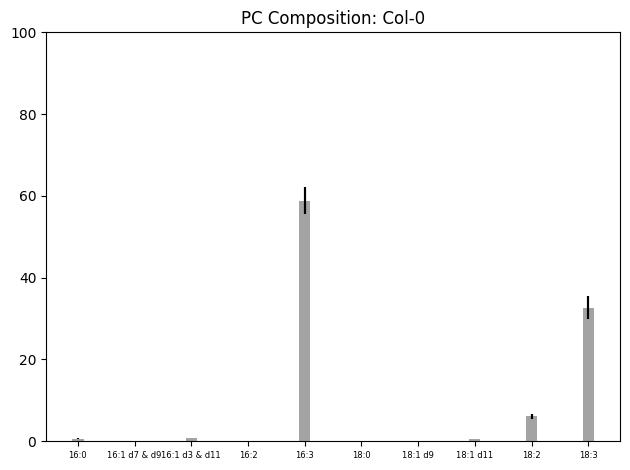

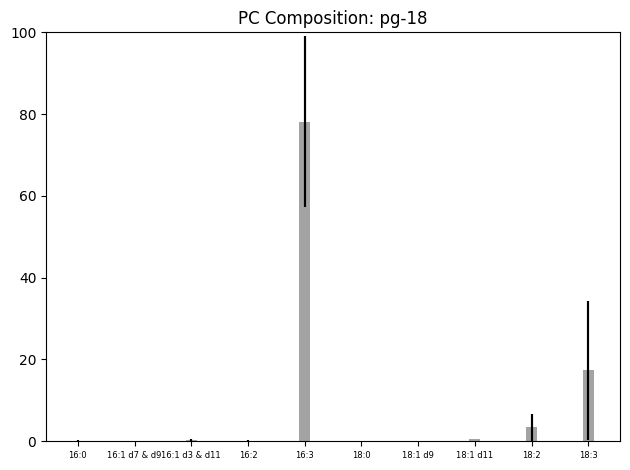

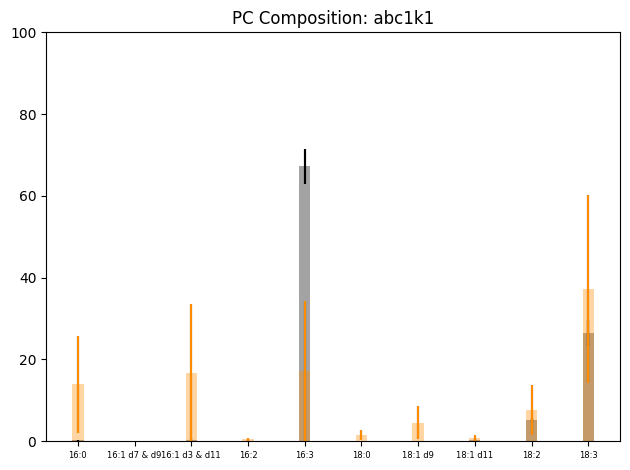

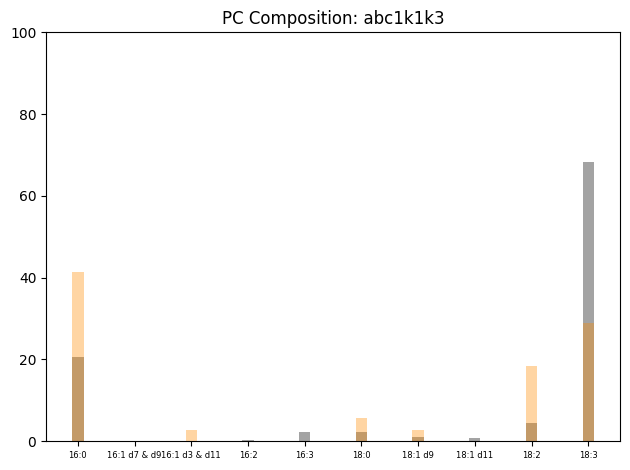

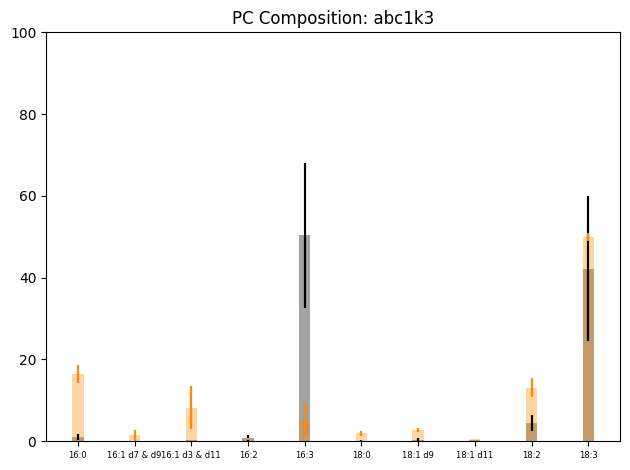

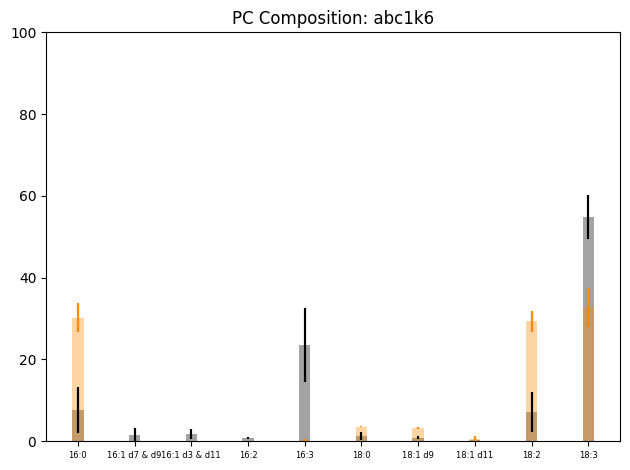

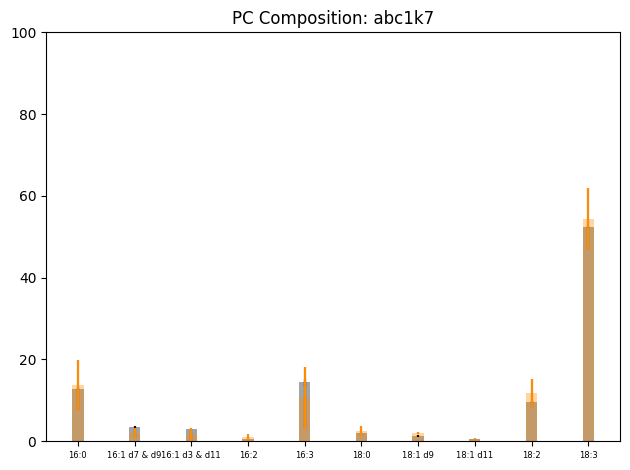

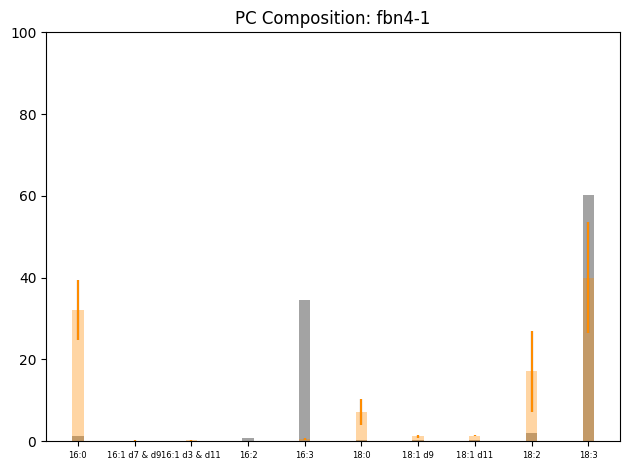

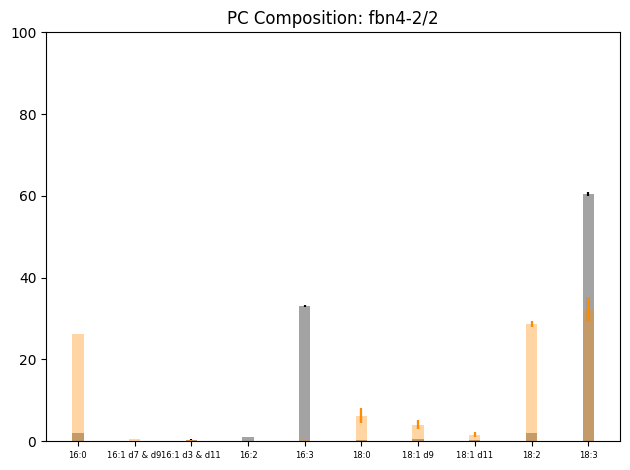

In [22]:
# For genotypes that do not have heat data: 
for genotype in ['Col-0', 'pg-18']:
    ax = plt.subplot(111)
    for condition in ['Control']:
        ax = plt.subplot(111)
        for lipid in ['PC']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()


for genotype in ['abc1k1', 'abc1k1k3', 'abc1k3', 'abc1k6', 'abc1k7', 'fbn4-1',
       'fbn4-2/2']:  # df1.index.get_level_values('Genotype ').unique():
    ax = plt.subplot(111)
    for condition in df1.index.get_level_values('Condition ').unique():
        ax = plt.subplot(111)
        for lipid in ['PC']:
            plt.title(lipid + ' Composition: ' + genotype)
            for column in columns_to_average: 
                x = column
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center',
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')])
                ax.bar(x, height = df1.loc[(genotype, condition, lipid), (column, 'mean')], 
                    color = condition_coloring[condition], alpha = 0.2, align = 'center', 
                    width = 0.2, 
                    yerr = df1.loc[(genotype, condition, lipid), (column, 'std')], ecolor = condition_coloring[condition])
                plt.ylim(0,100)
                plt.tick_params(axis = 'x', which = 'major', labelsize = 6)
            # plt.xticks(column)
    plt.tight_layout()
    plt.show()



In [233]:
# We want to get a heatmap of only the siginificant differences between the control and heat values 
    # So, we need to do a t_test to determine significance 

# Split DataFrame based on 'Condition'
df_control = df[df['Condition '] == 'Control']
df_heat = df[df['Condition '] == 'Heat']
# Import necessary libraries 
from scipy import stats as stats
# Create a new df to output the results into
DE_Lipids_df = pd.DataFrame(columns=['Genotype', 'Condition', 'Lipid Species', 'p-value',
        '16:0', '16:1 d7 & d9', '16:1 d3 & d11', '16:2', '16:3', '18:0', '18:1 d9', '18:1 d11', '18:2', '18:3'])
# Columns to perform the t_test on 
columns_to_average = ['16:0', '16:1 d7 & d9', '16:1 d3 & d11', '16:2', '16:3', '18:0', '18:1 d9', '18:1 d11', '18:2', '18:3']

# Find the common set of genotypes and lipid species between df_control and df_heat
common_genotypes = set(df_control['Genotype ']).intersection(df_heat['Genotype '])
common_lipid_species = set(df_control['Lipid Species']).intersection(df_heat['Lipid Species'])

# Drop rows containing NaN values
df = df.dropna()

# Perform the t-test on the updated DataFrame


# Iterate over the common genotypes and lipid species
for genotype in common_genotypes:
    for lipid_species in common_lipid_species:
        # Filter rows with the same genotype and lipid species in both conditions
        control_rows = df_control[(df_control['Genotype '] == genotype) & (df_control['Lipid Species'] == lipid_species)]
        heat_rows = df_heat[(df_heat['Genotype '] == genotype) & (df_heat['Lipid Species'] == lipid_species)]
        
        # Perform the t-test if there are common rows
        if len(control_rows) > 0 and len(heat_rows) > 0:
            # Extract the values for t-test
            control_values = control_rows[columns_to_average]
            heat_values = heat_rows[columns_to_average]
            
            # Perform the t-test between the corresponding rows
            statistic, pvalue = stats.ttest_ind(control_values, heat_values)
            
            # Create a new row with the statistical results
            new_row = {'Genotype': genotype, 'Condition': 'Heat', 'Lipid Species': lipid_species}
            new_row.update({column: stat for column, stat in zip(columns_to_average, statistic)})
            new_row.update({col + ' p-value': p for col, p in zip(columns_to_average, pvalue)})
            
            # Append the new row to DE_Lipids_df
            DE_Lipids_df = DE_Lipids_df.append(new_row, ignore_index=True)


# for genotype in df['Genotype '].unique():
#     for lipid_species in df['Lipid Species'].unique():
#         for column in columns_to_average:
#             statistic, pvalue = stats.ttest_ind(df_control[column], df_heat[column])
#             print(pvalue)
            # Import the t_test results into a new dataframe by index
#             new_row = {'Genotype': genotype, 'Condition': 'Control', 'Lipid Species': lipid_species, 'p-value': pvalue}
#             new_row.update({column: statistic for column in columns_to_average})
#             DE_Lipids_df = DE_Lipids_df.append(new_row, ignore_index=True)



# Generate a heatmap of the lipid data for the replicates that are differently expressed under lifetime heat treatment 

# Final plot outputs 
    # Find more cmap color options at the end of the page here: https://seaborn.pydata.org/tutorial/color_palettes.html
# Expands the image so that all protein names fit

# for temperature in ['Control', 'Heat']:
#     plt.figure(figsize=(8,10))
#         # Plotting the heatmap based on the df and labeled according to Genotype
#     for lipid in df['Lipid Species'].unique():
#         for genotype in df['Genotype '].unique():
#             if genotype == ['Col-0', 'pg-18', 'abc1k1', 'abc1k3', 'abc1k1k3', 'abc1k6', 'abc1k7', 'fbn4-1', 'fbn4-2/2']:
#                 sns.heatmap(lipid, yticklabels = genotype,
#                     cmap = 'Blues')
#             else: 
#                 continue
#     plt.title('Thylakoid Membrane Response to Heat in PG Mutants')




DE_Lipids_df

,Genotype,Condition,Lipid Species,p-value,16:0,16:1 d7 & d9,16:1 d3 & d11,16:2,16:3,18:0,...,16:0 p-value,16:1 d7 & d9 p-value,16:1 d3 & d11 p-value,16:2 p-value,16:3 p-value,18:0 p-value,18:1 d9 p-value,18:1 d11 p-value,18:2 p-value,18:3 p-value
0,fbn4-2/2,Heat,MGDG,NaN,1.439910,-2.191503,-1.000000,-1.000000,-1.041716,1.138816,...,0.286556,0.159763,0.422650,0.422650,0.406925,0.372808,0.320899,0.430524,0.636028,0.408393
1,fbn4-2/2,Heat,total FA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fbn4-2/2,Heat,PG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,fbn4-2/2,Heat,PC,NaN,-256.987770,-7.430596,0.674035,36.144783,134.265788,-3.157678,...,0.000015,0.017634,0.569754,0.000765,0.000055,0.087351,0.087480,0.151859,0.000841,0.011935
4,fbn4-2/2,Heat,DGDG,NaN,0.334543,-1.865173,-1.616432,-2.464164,-0.869342,-0.941182,...,0.769795,0.203155,0.247385,0.132686,0.476315,0.445963,0.410104,0.556241,0.883431,0.353684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,abc1k3,Heat,PG,NaN,-0.721788,NaN,-0.877060,1.000000,0.574058,-2.055086,...,0.545405,NaN,0.472953,0.422650,0.623885,0.176209,0.353522,0.477907,0.492745,0.945898
59,abc1k3,Heat,PC,NaN,-6.748034,-1.000000,-1.531184,0.324116,2.473214,-3.126050,...,0.021263,0.422650,0.265391,0.776607,0.131900,0.088897,0.068868,0.172328,0.099608,0.707591
60,abc1k3,Heat,DGDG,NaN,0.512038,-2.184959,-18.875911,-6.844215,0.752548,0.694283,...,0.659562,0.160503,0.002795,0.020688,0.530238,0.559310,0.001551,0.624161,0.072439,0.012773
61,abc1k3,Heat,SQDG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df1.drop(columns=['HeaderValue', 'SampleName', 'Location', 'Sample', '14:0', 'Genotype', 'Condition'])

,Lipid Species,16:0,16:1 d7 & d9,16:1 d3 & d11,16:2,16:3,18:0,18:1 d9,18:1 d11,18:2,18:3,Genotype,Condition,15:0
0,MGDG,0.000000,0.000000,0.034853,0.000000,78.852912,0.000000,0.000000,5.667583,4.487047,10.957604,Col-0,Control,NaN
1,PG,0.000000,0.000000,0.053750,0.000000,85.603245,0.000000,0.000000,2.619480,0.930244,10.793281,Col-0,Control,NaN
2,DGDG,0.000000,0.000000,0.033353,0.000000,89.735577,0.000000,0.000000,1.588760,0.542518,8.099791,Col-0,Control,NaN
3,SQDG,0.012878,0.000000,0.059916,0.000000,90.524389,0.000000,0.000000,2.751024,1.387402,5.264391,Col-0,Control,NaN
4,PI/PE,0.000000,0.000000,0.051434,0.000000,63.974300,0.000000,0.000000,0.842744,1.140372,33.991150,Col-0,Control,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,SQDG,20.259063,0.123409,0.135851,0.407755,1.051423,3.261417,1.766329,0.683628,9.412546,62.898579,fbn4-2/2,Heat,NaN
125,PI/PE,39.333472,0.000000,0.000000,0.000000,0.000000,4.628992,1.485537,1.094392,30.442219,23.015387,fbn4-2/2,Heat,NaN
126,PC,26.221261,0.523222,0.212233,0.000000,0.362739,6.268235,4.046392,1.577360,28.650497,32.138061,fbn4-2/2,Heat,NaN
127,total FA,14.829666,2.967585,2.983334,0.658703,8.148160,2.672314,1.922284,0.549835,14.004914,51.263205,fbn4-2/2,Heat,NaN


In [78]:
## Retired DH code

##################
# NEW Feb22-2018 #
##################

# create some oliver heatmaps using the data in "OUTPUT4_molpercentage_summary.csv"

# we will create one heatmap for each lipid
for lipid in set(df_molper_summary["Lipid"]):
    #if lipid =="TOTAL":
        #continue
    heatmap_data = {}
    lipid_df = df_molper_summary[df_molper_summary["Lipid"] == lipid]
    
    # the heatmap will contain one row for each genotype
    for genotype in set(lipid_df["Genotype"]):
        genotype_df = lipid_df[lipid_df["Genotype"] == genotype]
        heatmap_data[genotype] = genotype_df["mean"].values
    
    pd.DataFrame.from_dict( heatmap_data, orient="index" ).to_csv("oliver_output4_{0}.txt".format( lipid ), sep="\t" )

NameError: name 'df_molper_summary' is not defined

In [20]:
# OLD VERSION (see next cell for the new version)
# Lipid amount plot------------------------------------------------------------

# lgb_columns = pd.DataFrame([header.split( "_" ) for header in d3.index], columns = ["Lipid", "Genotype", "Biorep"] )
# lgb_columns.index = d3.index
# d32 = pandas.concat([d3.sum(axis=1), lgb_columns], axis=1, join_axes=[d3.index]) \
#     .rename(columns={0:'values'}) \
#     .pivot_table(index=["Genotype","Biorep"], columns='Lipid', values='values')

# totper = d32.divide( d32["TOTAL"].values*dilution_fold/100, axis=0 ) \
#     .drop('TOTAL',1) \
#     .reset_index() \
#     .melt(id_vars=["Genotype","Biorep"], var_name='Lipid', value_name='values' ) \
#     .groupby(['Lipid', 'Genotype']) \
#     .agg([len, np.mean, np.std, se]) \
#     .reset_index()

# #rename and reorder columns to match R script
# totper.columns = ['Lipid','Genotype','N','mean','sd','se']
# totper = totper[['Genotype','Lipid','N','mean','sd','se']]
# totper = totper.sort_values(["Genotype", "Lipid"])

# totper.to_csv("OUTPUT5_lipid_composition_summary.csv", index=False, na_rep="NaN")

In [21]:
##################
# NEW Feb22-2018 #
##################

# this is the updated version of the commented cell above
# this was created by translating lines 183-207 in lipid_analysis_R6_DH.R

tot = df_mol[df_mol["Lipid"] != "TOTAL"] \
        .groupby(["Genotype","Biorep"]) \
        .sum()
tot = [x[0] for x in tot.values]
        
totfa_ = df_mol[df_mol["Lipid"] != "TOTAL"] \
        .groupby(["Genotype","Biorep","Lipid"]) \
        .sum() \
        .reset_index() 
totfa_ = pd.pivot_table(totfa_, index=['Genotype', 'Biorep'], columns='Lipid' ) \
        .reset_index() 
totfa = totfa_["values"]
totfa["Biorep"] = totfa_["Biorep"].values
totfa["Genotype"] = totfa_["Genotype"].values
totfa = totfa.reset_index()
totfa = totfa.drop("index", axis=1)
totfa.columns.name = None

totper = totfa.loc[:, ~(totfa.columns.isin( ['Genotype','Biorep'] ))]
for col in totper.columns:
    totper[col] = np.divide( totper[col].values, tot ) * 100
totper["Genotype"] = totfa["Genotype"]
totper["DGDG/MGDG"] = totper["DGDG"]/totper["MGDG"]

groups = totper \
        .melt( id_vars=["Genotype"], var_name="Lipid") \
        .groupby(["Genotype","Lipid"])

totper_ = groups \
        .describe(percentiles=[]) \
        .reset_index()

group_values = groups \
        .agg(lambda x: list(x)) \
        .reset_index()["value"]


totper = pd.DataFrame()
totper["Genotype"] = totper_["Genotype"]
totper["Lipid"] = totper_["Lipid"]
totper["N"] = totper_["value"]["count"]
totper["mean"] = totper_["value"]["mean"]
totper["sd"] = totper_["value"]["std"]
totper["se"] = np.divide( totper["sd"], np.sqrt(totper["N"]) )
totper["values"] = group_values

totper.to_csv( "OUTPUT5_lipid_composition_summary.csv" )

In [22]:
# settings for plots



geno_colors = {
    '125BCOLD': "blue", 
    '125BCONT': "navy", 
    'CB27COLD': "orange", 
    'CB27CONT': "orangered", 
    'Practice': "gray"
}



# this is the order genotypes will appear in plots
# genotypes can also be ommitted here
geno_order = [ 'CB27CONT','125BCONT']

StopIteration: 

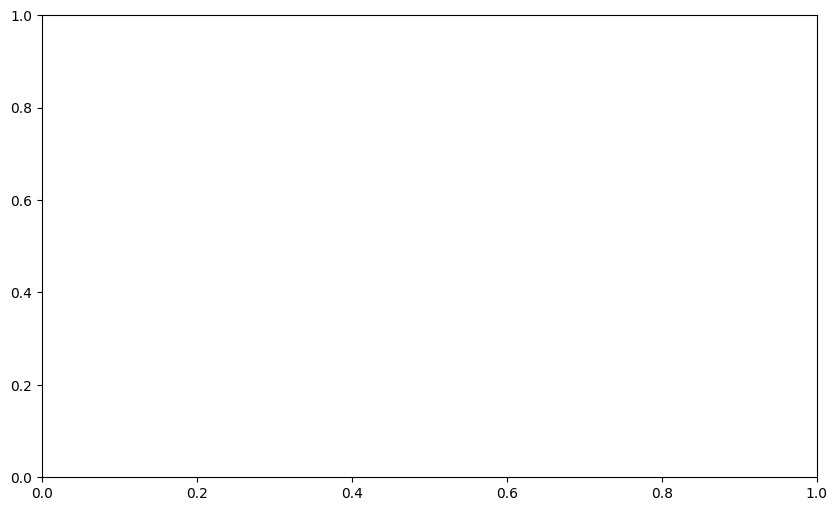

In [26]:
# build some bar plot swith error bars

# one figure for each lipid

# one legend entry for each genotype
# one x-value for each FA

# bar height is acyl group mol%

all_lipids = set(df_molper_summary["Lipid"])
all_fas = sorted(list(set(df_molper_summary["FA"])))

x_labels = all_fas
x = np.array(range(len(x_labels)))*1.3

for lipid in all_lipids:
    df_lipid = df_molper_summary[df_molper_summary["Lipid"] == lipid]
    
    fig,ax = plt.subplots(1,1, figsize=(10,6))
    
    for offset,geno in enumerate(geno_order):
        df_sub = df_lipid[df_lipid["Genotype"] == geno]
        
        y,yerr = [],[]
        for fa in x_labels:
            matching_row = df_sub[df_sub["FA"] == fa].index
            if len(matching_row) == 0:
                y.append( np.nan )
                yerr.append(np.nan)
            else:
                y.append( df_sub.loc[matching_row[0],"mean"] )
                yerr.append( df_sub.loc[matching_row[0],"sd"] )
                
        ax.bar( x+offset/len(geno_order), y, yerr=yerr, width=1/len(geno_order),
              label=geno, color=geno_colors[geno])

    # add legend tot he right of the plot
    ax.set_position([.1,.3,.6,.6])
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Genotype", fontsize=16)
    plt.setp(legend.get_title(),fontsize=20)
    
    ax.set_xticks(x+.5-(.5/len(geno_order)))
    ax.set_xticklabels(x_labels,rotation=60, fontsize=16)
    ax.set_ylim(0,ax.get_ylim()[1])
    ax.set_ylabel("Acyl groups (mol%)", fontsize=20)
    ax.tick_params(axis='y', labelsize=16 )
    
    ax.set_title(lipid,fontsize=20)
    fig.savefig(lipid+".png", dpi=300)
    fig.show()
        

KeyError: 'mean'

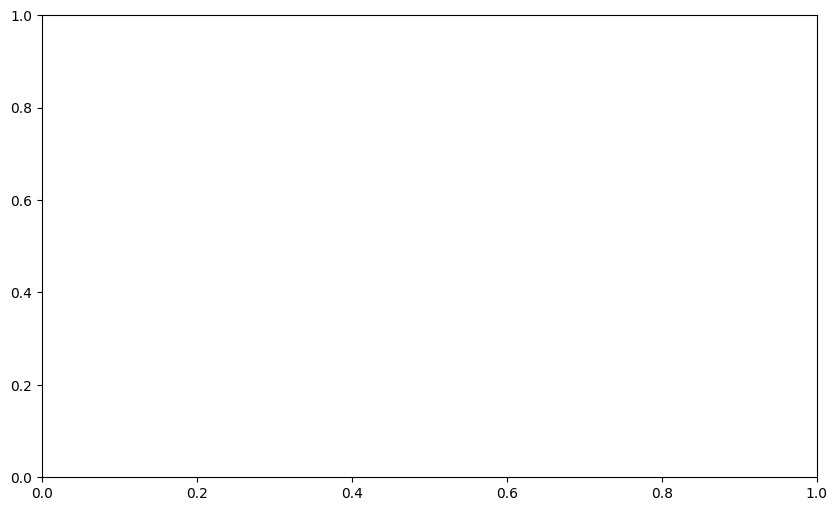

In [27]:
# total lipid composition
# one figure

# one legend entry for each genotype
# one x-value for each lipid

# bar height is acyl groups mol%


# manually set order for lipids
all_lipids = [ "MGDG","DGDG", "PG","PIPE","PC", "SQDG"]


x_labels = all_lipids
x = np.array(range(len(x_labels)))*1.3

fig,ax = plt.subplots(1,1, figsize=(10,6))
    
for offset,geno in enumerate(geno_order):
    df_sub = totper[totper["Genotype"] == geno]

    y,yerr = [],[]
    for lipid in x_labels:
        matching_row = df_sub[df_sub["Lipid"] == lipid].index
        if len(matching_row) == 0:
            y.append( np.nan )
            yerr.append(np.nan)
        else:
            y.append( df_sub.loc[matching_row[0],"mean"] )
            yerr.append( df_sub.loc[matching_row[0],"sd"] )

    ax.bar( x+offset/len(geno_order), y, yerr=yerr, width=1/len(geno_order),
              label=geno, color=geno_colors[geno])

# add legend and labels
ax.set_position([.1,.3,.6,.6])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Genotype", fontsize=16)
plt.setp(legend.get_title(),fontsize=20)
ax.set_xticks(x+.5-(.5/len(geno_order)))
ax.set_xticklabels(x_labels,rotation=60, fontsize=16)
ax.set_ylim(0,ax.get_ylim()[1])
ax.set_ylabel("Acyl groups (mol%)", fontsize=20)
ax.tick_params(axis='y', labelsize=16 )

# save image and show figure
ax.set_title("Total Lipid Composition",fontsize=20)
fig.savefig("Total Lipid Composition.png", dpi=300)
fig.show()


In [25]:
# settings for plots



geno_colors = {
    '125BCOLD': "blue", 
    '125BCONT': "navy", 
    'CB27COLD': "orange", 
    'CB27CONT': "orangered", 
    'Practice': "gray"
}



# this is the order genotypes will appear in plots
# genotypes can also be ommitted here
geno_order = [ 'CB27COLD', '125BCOLD', ]

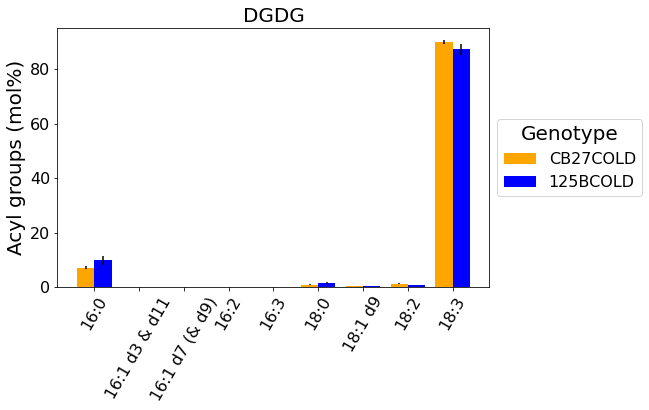

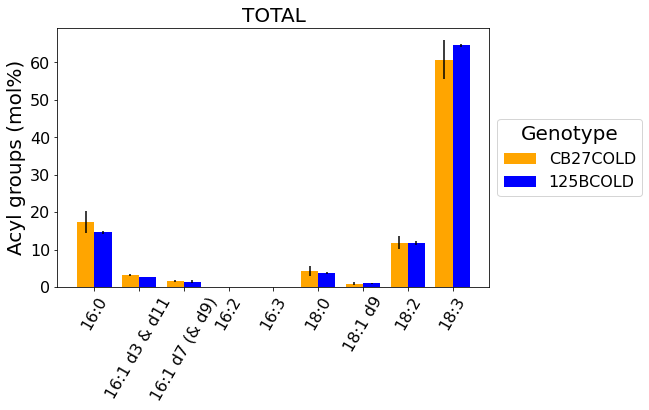

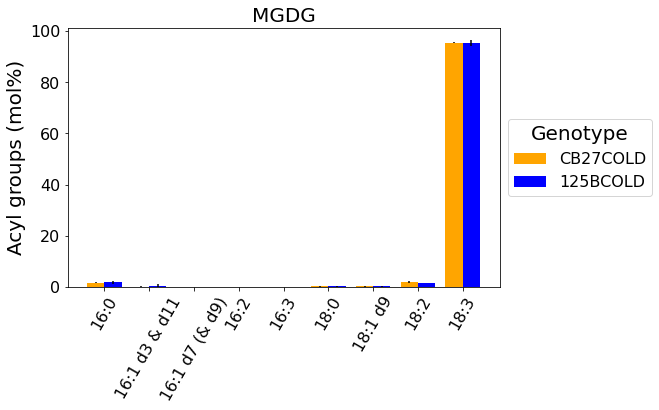

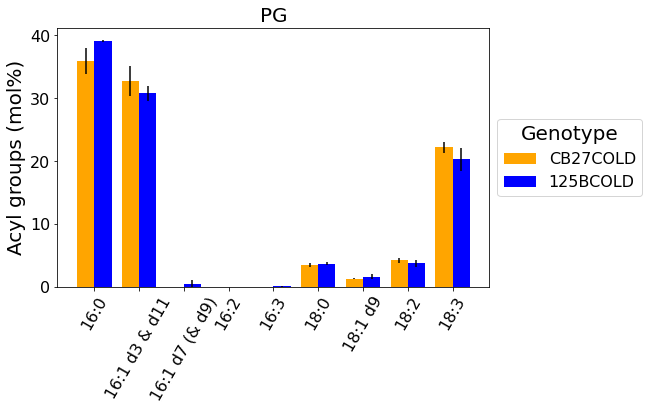

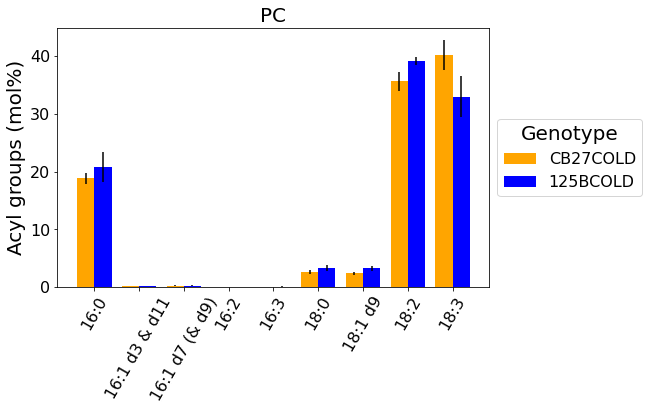

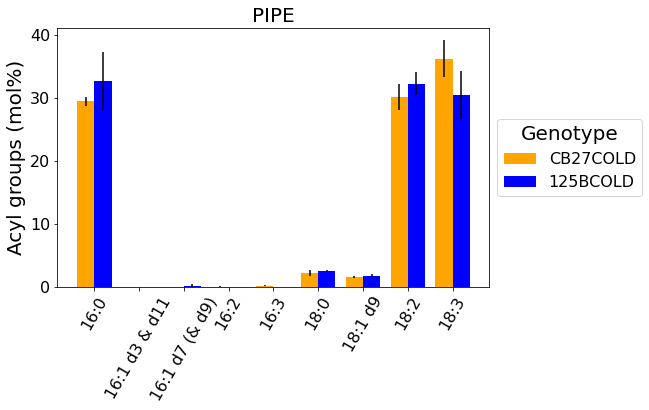

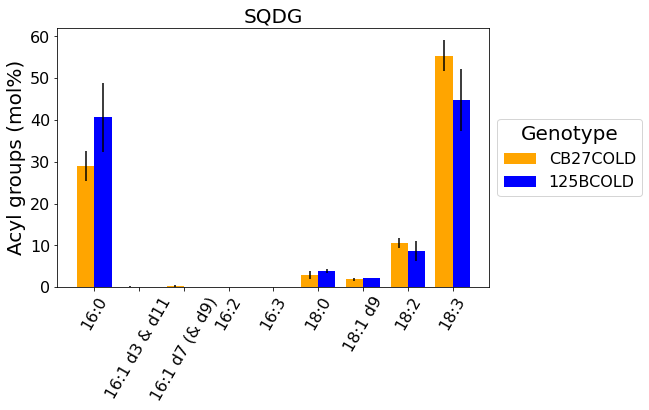

In [26]:
# build some bar plot swith error bars

# one figure for each lipid

# one legend entry for each genotype
# one x-value for each FA

# bar height is acyl group mol%

all_lipids = set(df_molper_summary["Lipid"])
all_fas = sorted(list(set(df_molper_summary["FA"])))

x_labels = all_fas
x = np.array(range(len(x_labels)))*1.3

for lipid in all_lipids:
    df_lipid = df_molper_summary[df_molper_summary["Lipid"] == lipid]
    
    fig,ax = plt.subplots(1,1, figsize=(10,6))
    
    for offset,geno in enumerate(geno_order):
        df_sub = df_lipid[df_lipid["Genotype"] == geno]
        
        y,yerr = [],[]
        for fa in x_labels:
            matching_row = df_sub[df_sub["FA"] == fa].index
            if len(matching_row) == 0:
                y.append( np.nan )
                yerr.append(np.nan)
            else:
                y.append( df_sub.loc[matching_row[0],"mean"] )
                yerr.append( df_sub.loc[matching_row[0],"sd"] )
                
        ax.bar( x+offset/len(geno_order), y, yerr=yerr, width=1/len(geno_order),
              label=geno, color=geno_colors[geno])

    # add legend tot he right of the plot
    ax.set_position([.1,.3,.6,.6])
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Genotype", fontsize=16)
    plt.setp(legend.get_title(),fontsize=20)
    
    ax.set_xticks(x+.5-(.5/len(geno_order)))
    ax.set_xticklabels(x_labels,rotation=60, fontsize=16)
    ax.set_ylim(0,ax.get_ylim()[1])
    ax.set_ylabel("Acyl groups (mol%)", fontsize=20)
    ax.tick_params(axis='y', labelsize=16 )
    
    ax.set_title(lipid,fontsize=20)
    fig.savefig(lipid+".png", dpi=300)
    fig.show()
        

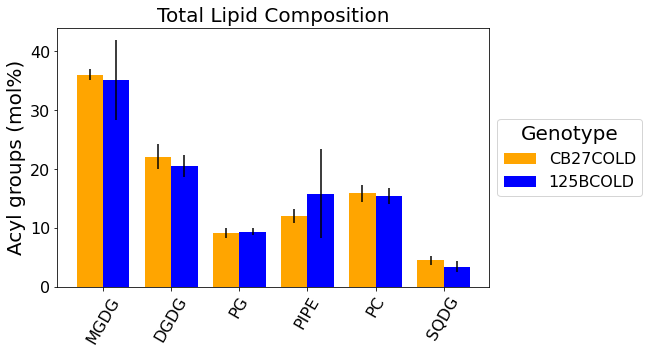

In [27]:
# total lipid composition
# one figure

# one legend entry for each genotype
# one x-value for each lipid

# bar height is acyl groups mol%


# manually set order for lipids
all_lipids = [ "MGDG","DGDG", "PG","PIPE","PC", "SQDG"]


x_labels = all_lipids
x = np.array(range(len(x_labels)))*1.3

fig,ax = plt.subplots(1,1, figsize=(10,6))
    
for offset,geno in enumerate(geno_order):
    df_sub = totper[totper["Genotype"] == geno]

    y,yerr = [],[]
    for lipid in x_labels:
        matching_row = df_sub[df_sub["Lipid"] == lipid].index
        if len(matching_row) == 0:
            y.append( np.nan )
            yerr.append(np.nan)
        else:
            y.append( df_sub.loc[matching_row[0],"mean"] )
            yerr.append( df_sub.loc[matching_row[0],"sd"] )

    ax.bar( x+offset/len(geno_order), y, yerr=yerr, width=1/len(geno_order),
              label=geno, color=geno_colors[geno])

# add legend and labels
ax.set_position([.1,.3,.6,.6])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Genotype", fontsize=16)
plt.setp(legend.get_title(),fontsize=20)
ax.set_xticks(x+.5-(.5/len(geno_order)))
ax.set_xticklabels(x_labels,rotation=60, fontsize=16)
ax.set_ylim(0,ax.get_ylim()[1])
ax.set_ylabel("Acyl groups (mol%)", fontsize=20)
ax.tick_params(axis='y', labelsize=16 )

# save image and show figure
ax.set_title("Total Lipid Composition",fontsize=20)
fig.savefig("Total Lipid Composition.png", dpi=300)
fig.show()



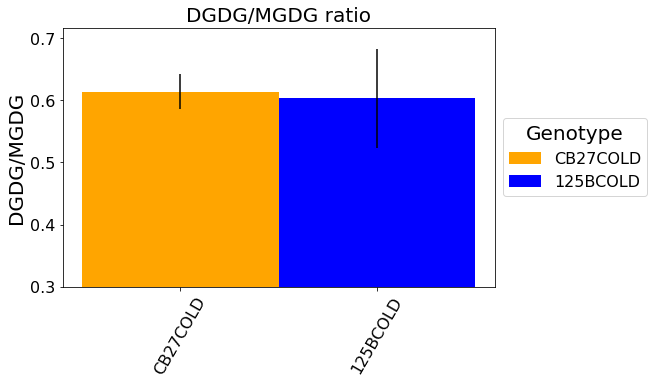

In [28]:
# same figure showing just DGDG/MGDG

lipid = "DGDG/MGDG"

fig,ax = plt.subplots(1,1, figsize=(10,6))
    
for x,geno in enumerate(geno_order):
    matching_row = totper[(totper["Genotype"] == geno) & (totper["Lipid"] == lipid)].index
    if len(matching_row) == 0:
        continue
        
    y = totper.loc[matching_row[0],"mean"] 
    yerr = totper.loc[matching_row[0],"se"] 
    ax.bar( x, y, yerr=yerr, width=1,
              label=geno, color=geno_colors[geno])

# add legend and labels
ax.set_position([.1,.3,.6,.6])
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Genotype", fontsize=16)
plt.setp(legend.get_title(),fontsize=20)
ax.set_xticks(range(len(geno_order)))
ax.set_xticklabels(geno_order,rotation=60, fontsize=16)
#ax.set_ylim(0,ax.get_ylim()[1])
ax.set_ylim(0.3,ax.get_ylim()[1])
ax.set_ylabel("DGDG/MGDG", fontsize=20)
ax.tick_params(axis='y', labelsize=16 )

# save image and show figure
ax.set_title("DGDG/MGDG ratio",fontsize=20)
fig.savefig("ratio.png", dpi=300)
fig.show()


In [15]:
# show DGDG/MGDG data
df = totper[totper["Lipid"] == "DGDG/MGDG"].drop("Lipid",axis=1)
df.index = df["Genotype"]
df = df.drop("Genotype", axis=1)
df

,N,mean,sd,se,values
Genotype,,,,,
125BCOLD,3.0,0.603022,0.138090,0.079726,"[0.730488782318442, 0.456325224152098, 0.62225..."
125BCONT,3.0,0.637221,0.080208,0.046308,"[0.5718812799864328, 0.7267358968826432, 0.613..."
CB27COLD,4.0,0.613974,0.057633,0.028816,"[0.5298587332957218, 0.6371182837073679, 0.660..."
CB27CONT,4.0,0.498199,0.145860,0.072930,"[0.44679317311926786, 0.4204254219860457, 0.40..."
Practice,1.0,1.908575,NaN,NaN,[1.908575083505487]


In [16]:
# show t-test results for each pair of genotypes
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

all_genotypes = list( set(df.index) - {"Practice"} )

for a,geno_a in enumerate(all_genotypes):
    for b,geno_b in enumerate(all_genotypes):
        if a < b:
            a_vals = df.loc[geno_a,"values"]
            b_vals = df.loc[geno_b,"values"]
            t,p = ttest_ind(a_vals,b_vals)
            print( "\n{0} vs {1}\n\tt-statistic: {2:.3f}\n\tp-value: {3:.3f}".format( geno_a, geno_b, t, p ) )


CB27CONT vs 125BCONT
	t-statistic: -1.470
	p-value: 0.202

CB27CONT vs CB27COLD
	t-statistic: -1.476
	p-value: 0.190

CB27CONT vs 125BCOLD
	t-statistic: -0.961
	p-value: 0.381

125BCONT vs CB27COLD
	t-statistic: 0.450
	p-value: 0.671

125BCONT vs 125BCOLD
	t-statistic: 0.371
	p-value: 0.730

CB27COLD vs 125BCOLD
	t-statistic: 0.146
	p-value: 0.889
